In [198]:
import pandas as pd
from math import sqrt
import numpy as np

pd.set_option('max_colwidth', 70)
%matplotlib inline

def ExpMovingAverage(values, window):
        weights = np.exp(np.linspace(-1., 0., window))
        weights /= weights.sum()
        a =  np.convolve(values, weights, mode='full')[:len(values)]
        a[:window] = a[window]
        return a

# Simplified Uniswap Model
## Introduction to Uniswap
>Uniswap is an automated market maker for exchanging ERC20 tokens. Anyone can become a liquidity provider, and invest in the liquidity pool of an ERC20 token. This allows other users to trade that token for other tokens at an exchange rate based on their relative availibility. When a token trade is executed, a small fee is paid to the liquidity providers that enabled the transaction.
https://uniswap.io/

There are basically eight ways (_mechanisms_) in which an agent can interact with an instance of Uniswap:
1. `addLiquidity`: deposit ETH and tokens in the liquidity pool; mint UNI tokens - "shares" of that Uniswap instance - in exchange;
1. `removeLiquidity`: burn UNI tokens; withdraw a proportional amount of ETH and tokens in exchange;
1. `ethToTokenInput`: user specifies an exact amount of ETH they send; receives corresponding amount of tokens
1. `ethToTokenOutput`: user sends some ETH and specifies an exact amount of tokens they want to buy; Uniswap refunds ETH sent in excess
1. `tokenToEthInput`: user specifies an exact amount of tokens they send; receives corresponding amount of ETH
1. `tokenToEthOutput`: user specifies an exact amount of ETH they want to buy; Uniswap takes the corresponding amount of tokens from the user account
1. `tokenToTokenInput`: user specifies an exact amount of "token A" they send; receives corresponding amount of "token B" (effectively a `tokenToEthInput` in instance A combined with a `ethToTokenInput` in instance B)
1. `tokenToTokenOutput`: user specifies an exact amount of "token B˜ they want to buy; Uniswap takes the corresponding amount of "token A" from the user account (effectively a `ethToTokenOutput` in instance B combined with a `tokenToEthOutput` in instance A)

## Limitations and simplifications of this model
* When triggering mechanisms, Uniswap users may include conditions they would like to apply to the transaction. For example, they could define a minimum amount of UNI tokens they wish to receive as a result of adding liquidity to the pool; or the maximum number of tokens they are willing to pay for the amount of ETH requested in a `tokenToEthOutput` operation; or a deadline after which the transaction should not be processed. **This simplified model does not account for this kind conditioning.**

* The `ethToTokenOutput`, `tokenToEthOutput` mechanisms are not implemented. **All swaps are treated as of the "input defined" type.**

* The `tokenToToken` mechanism are not implemented, as they are merely a `tokenToEth` in the context of a single Uniswap instance.

* **User _behavior_ has not been modeled**. User _actions_ are derived from the history of events of the Uniswap instance being analyzed.

_____________

## MODEL

### Initial conditions
These are the initial conditions of the [DAI-ETH Uniswap instance](https://etherscan.io/address/0x09cabEC1eAd1c0Ba254B09efb3EE13841712bE14)

In [199]:
state = {
    'DAI_balance': 5900000000000000000000,
    'ETH_balance': 30000000000000000000
    
}
state['UNI_supply'] = state['ETH_balance']
state

{'DAI_balance': 5900000000000000000000,
 'ETH_balance': 30000000000000000000,
 'UNI_supply': 30000000000000000000}

### Parameters
These are the parameters of Uniswap that represent the fee collected on each swap. Notice that these are hardcoded in the Uniswap smart contracts, but we model them as parameters in order to be able to do A/B testing and parameter sweeping on them in the future.

In [200]:
params = {
    'fee_numerator': 997,
    'fee_denominator': 1000
}
params

{'fee_numerator': 997, 'fee_denominator': 1000}

### Mechanisms
In order to better mimic the behavior of Uniswap, we need to pay special attention to two things:
1. make explicit that we want numbers to be treated as integers by the Python interpreter - there are probably more casts to `int` than needed throughout the code;
1. Uniswap was coded in Vyper, where the `/` operator applied to integer variables returns the dividend of the division. In order to achieve the same in Python, we need to use _"floor division"_ (`//`) instead of _"true division"_ (`/`).

In [201]:
expr = '10000000000000000000 / 5000000000000000001'
print(f'{expr} = {eval(expr)}')
expr = 'int(10000000000000000000 / 5000000000000000001)'
print(f'{expr} = {eval(expr)}')
expr = '10000000000000000000 // 5000000000000000001'
print(f'{expr} = {eval(expr)}')

10000000000000000000 / 5000000000000000001 = 2.0
int(10000000000000000000 / 5000000000000000001) = 2
10000000000000000000 // 5000000000000000001 = 1


### Mechanism - addLiquidity

In [202]:
# def addLiquidity(min_liquidity: uint256, max_tokens: uint256, deadline: timestamp) -> uint256:
#     assert deadline > block.timestamp and (max_tokens > 0 and msg.value > 0)
#     total_liquidity: uint256 = self.totalSupply
#     if total_liquidity > 0:
#         assert min_liquidity > 0
#         eth_reserve: uint256(wei) = self.balance - msg.value
#         token_reserve: uint256 = self.token.balanceOf(self)
#         token_amount: uint256 = msg.value * token_reserve / eth_reserve + 1
#         liquidity_minted: uint256 = msg.value * total_liquidity / eth_reserve
#         assert max_tokens >= token_amount and liquidity_minted >= min_liquidity
#         self.balances[msg.sender] += liquidity_minted
#         self.totalSupply = total_liquidity + liquidity_minted
#         assert self.token.transferFrom(msg.sender, self, token_amount)
#         log.AddLiquidity(msg.sender, msg.value, token_amount)
#         log.Transfer(ZERO_ADDRESS, msg.sender, liquidity_minted)
#         return liquidity_minted

def addLiquidity_UNI(params, step, history, current_state, input_):
    total_liquidity = int(current_state['UNI_supply'])
    eth_reserve = int(current_state['ETH_balance'])
    liquidity_minted = int(input_['eth_deposit'] * total_liquidity // eth_reserve)
    return ('UNI_supply', total_liquidity + liquidity_minted)

def addLiquidity_ETH(params, step, history, current_state, input_):
    eth_reserve = int(current_state['ETH_balance'])
    return ('ETH_balance', eth_reserve + input_['eth_deposit'])

def addLiquidity_DAI(params, step, history, current_state, input_):
    eth_reserve = int(current_state['ETH_balance'])
    token_reserve = int(current_state['DAI_balance'])
    if input_['eth_deposit'] == 0:
        token_amount = 0
    else:
        token_amount = int(input_['eth_deposit'] * token_reserve // eth_reserve + 1)
    return ('DAI_balance', token_reserve + token_amount)

### Mechanism - removeLiquidity

In [203]:
# def removeLiquidity(amount: uint256, min_eth: uint256(wei), min_tokens: uint256, deadline: timestamp) -> (uint256(wei), uint256):
#     assert (amount > 0 and deadline > block.timestamp) and (min_eth > 0 and min_tokens > 0)
#     total_liquidity: uint256 = self.totalSupply
#     assert total_liquidity > 0
#     token_reserve: uint256 = self.token.balanceOf(self)
#     eth_amount: uint256(wei) = amount * self.balance / total_liquidity
#     token_amount: uint256 = amount * token_reserve / total_liquidity
#     assert eth_amount >= min_eth and token_amount >= min_tokens
#     self.balances[msg.sender] -= amount
#     self.totalSupply = total_liquidity - amount
#     send(msg.sender, eth_amount)
#     assert self.token.transfer(msg.sender, token_amount)
#     log.RemoveLiquidity(msg.sender, eth_amount, token_amount)
#     log.Transfer(msg.sender, ZERO_ADDRESS, amount)
#     return eth_amount, token_amount

def removeLiquidity_UNI(params, step, history, current_state, input_):
    total_liquidity = int(current_state['UNI_supply'])
    amount = int(input_['UNI_burn'])
    return ('UNI_supply', int(total_liquidity - amount))

def removeLiquidity_ETH(params, step, history, current_state, input_):
    total_liquidity = int(current_state['UNI_supply'])
    eth_reserve = int(current_state['ETH_balance'])
    amount = int(input_['UNI_burn'])
    eth_amount = int(amount * eth_reserve // total_liquidity)
    return ('ETH_balance', int(eth_reserve - eth_amount))

def removeLiquidity_DAI(params, step, history, current_state, input_):
    total_liquidity = int(current_state['UNI_supply'])
    token_reserve = int(current_state['DAI_balance'])
    amount = int(input_['UNI_burn'])
    token_amount = int(amount * token_reserve // total_liquidity)
    return ('DAI_balance', int(token_reserve - token_amount))

### Auxiliary function - getInputPrice

In [204]:
# @dev Pricing function for converting between ETH and Tokens.
# @param input_amount Amount of ETH or Tokens being sold.
# @param input_reserve Amount of ETH or Tokens (input type) in exchange reserves.
# @param output_reserve Amount of ETH or Tokens (output type) in exchange reserves.
# @return Amount of ETH or Tokens bought.
def getInputPrice(input_amount, input_reserve, output_reserve, params):
    fee_numerator = params['fee_numerator']
    fee_denominator = params['fee_denominator']
    input_amount_with_fee = input_amount * fee_numerator
    numerator = input_amount_with_fee * output_reserve
    denominator = (input_reserve * fee_denominator) + input_amount_with_fee
    return int(numerator // denominator)

### Mechanism - ethToToken

In [205]:
# @private
# def ethToTokenInput(eth_sold: uint256(wei), min_tokens: uint256, deadline: timestamp, buyer: address, recipient: address) -> uint256:
#     assert deadline >= block.timestamp and (eth_sold > 0 and min_tokens > 0)
#     token_reserve: uint256 = self.token.balanceOf(self)
#     tokens_bought: uint256 = self.getInputPrice(as_unitless_number(eth_sold), as_unitless_number(self.balance - eth_sold), token_reserve)
#     assert tokens_bought >= min_tokens
#     assert self.token.transfer(recipient, tokens_bought)
#     log.TokenPurchase(buyer, eth_sold, tokens_bought)
#     return tokens_bought

def ethToToken_ETH(params, step, history, current_state, input_):
    eth_sold = int(input_['eth_sold']) #amount of ETH being sold by the user
    eth_reserve = int(current_state['ETH_balance'])
    return ('ETH_balance', eth_reserve + eth_sold)

def ethToToken_DAI(params, step, history, current_state, input_):
    eth_sold = int(input_['eth_sold']) #amount of ETH being sold by the user
    eth_reserve = int(current_state['ETH_balance'])
    token_reserve = int(current_state['DAI_balance'])
    if eth_sold == 0:
        return ('DAI_balance', token_reserve)
    else:
        tokens_bought = int(getInputPrice(eth_sold, eth_reserve, token_reserve, params))
        return ('DAI_balance', token_reserve - tokens_bought)

### Mechanism - tokenToEth

In [206]:
# @private
# def tokenToEthInput(tokens_sold: uint256, min_eth: uint256(wei), deadline: timestamp, buyer: address, recipient: address) -> uint256(wei):
#     assert deadline >= block.timestamp and (tokens_sold > 0 and min_eth > 0)
#     token_reserve: uint256 = self.token.balanceOf(self)
#     eth_bought: uint256 = self.getInputPrice(tokens_sold, token_reserve, as_unitless_number(self.balance))
#     wei_bought: uint256(wei) = as_wei_value(eth_bought, 'wei')
#     assert wei_bought >= min_eth
#     send(recipient, wei_bought)
#     assert self.token.transferFrom(buyer, self, tokens_sold)
#     log.EthPurchase(buyer, tokens_sold, wei_bought)
#     return wei_bought

def tokenToEth_ETH(params, step, history, current_state, input_):
    tokens_sold = int(input_['tokens_sold']) #amount of tokens being sold by the user
    eth_reserve = int(current_state['ETH_balance'])
    if tokens_sold == 0:
        return ('ETH_balance', eth_reserve)
    else:
        token_reserve = int(current_state['DAI_balance'])
        eth_bought = int(getInputPrice(tokens_sold, token_reserve, eth_reserve, params))
        return ('ETH_balance', eth_reserve - eth_bought)
    
def tokenToEth_DAI(params, step, history, current_state, input_):
    tokens_sold = int(input_['tokens_sold']) #amount of tokens being sold by the user
    token_reserve = int(current_state['DAI_balance'])
    return ('DAI_balance', token_reserve + tokens_sold)

### Events dataset
The events dataset was generated using [Kaggle/BigQuery](https://www.kaggle.com/markusbkoch/uniswap-ethdai-exchange/), as is available for download [here](https://www.kaggleusercontent.com/kf/21051736/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..HdZwILo7rBzA0baBSYIogA.5sWqgw2JU7MhBWp6MFRE2kpUJPQyAsOmljPX3jRGeEJMY5bYdZNjeW6XsuOkVDe8v4wcL5Efa3EpkrrC7bu-RLKqEEHazP2L5IQHGoYhschgBumjaoR2VPGM4xL40abyFTesKlVHGef2EIIlwpvHX0DcNrMQI-MpyVEjMSHx_oY.kBNFGv1rap1qLe-tfqQA6A/uniswap_events.pickle).

In [207]:
uniswap_events = pd.read_pickle('uniswap_events.pickle')
uniswap_events

,transactionHash,transaction_index,transaction_sender,address,data,topics,block_timestamp,blockNumber_dec,contract,event,contract_event,block_group,agent,eth_delta,token_delta,uni_delta,eth_balance,token_balance,UNI_supply,invariant
0,0xbd773ccc33c831378f2aa2b7d4a9ae8a20ed9112ea9acb86ce96aa674c0cb5f9,150,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x06239653922ac7bea6aa2b19dc486b9361821d37712eb796adfd38d81de278c...,2018-11-02 10:27:36+00:00,6629139,DAI,AddLiquidity,DAIAddLiquidity,662,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,30000000000000000000,5900000000000000000000,0,30000000000000000000,5900000000000000000000,0,177000000000000000000000000000000000000000
1,0xbd773ccc33c831378f2aa2b7d4a9ae8a20ed9112ea9acb86ce96aa674c0cb5f9,150,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x000000000000000000000000000000000000000000000001a055690d9db80000,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3e...,2018-11-02 10:27:36+00:00,6629139,DAI,Transfer,DAITransfer,662,0x0000000000000000000000000000000000000000,0,0,30000000000000000000,30000000000000000000,5900000000000000000000,30000000000000000000,177000000000000000000000000000000000000000
2,0xd53f01fc0cabbf4083da93a023ddb81de91320027077849ac982f7bc04b49279,97,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x7f4091b46c33e918a0f3aa42307641d17bb67029427a5369e54b35398423870...,2018-11-02 10:33:56+00:00,6629171,DAI,EthPurchase,DAIEthPurchase,662,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,-25326059253325791,5000000000000000000,0,29974673940746674209,5905000000000000000000,30000000000000000000,177000449620109111204145000000000000000000
3,0x53172898dbe437c784f7e4ac757087b28d1b06aa6b72b81d4a6bb2bead50c93e,53,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x7f4091b46c33e918a0f3aa42307641d17bb67029427a5369e54b35398423870...,2018-11-02 10:35:47+00:00,6629177,DAI,EthPurchase,DAIEthPurchase,662,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,-10118429075406013,2000000000000000000,0,29964555511671268196,5907000000000000000000,30000000000000000000,177000629407442181233772000000000000000000
4,0x6cef57fd37d7a2602c1236ff080c61c37e10980c7e3bd66de6f4e0ed52f16011,24,0x11e4857bb9993a50c685a79afad4e6f65d518dda,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0xcd60aa75dea3072fbc07ae6d7d856b5dc5f4eee88854f5b4abf7b680ef8bc50...,2018-11-02 10:38:18+00:00,6629190,DAI,TokenPurchase,DAITokenPurchase,662,0x11e4857bb9993a50c685a79afad4e6f65d518dda,10000000000000000,-1964761376358359468,0,29974555511671268196,5905035238623641640532,30000000000000000000,177000806558499339943044863018842396120272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101481,0xe9286e3e23957063046d6299eca0a5c724a034a0566a78754f5f23613a4b0312,40,0x4b8673ca1b5c9f08cfffce527fec9173c35e27f3,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x7f4091b46c33e918a0f3aa42307641d17bb67029427a5369e54b35398423870...,2019-09-23 23:37:04+00:00,8608422,DAI,EthPurchase,DAIEthPurchase,860,0x4b8673ca1b5c9f08cfffce527fec9173c35e27f3,-198016436809685891,40000000000000000000,0,6302047541877387309207,1269256071848791636644352,5320135262833503868378,7998912107607625827109961968988225660114148864
101482,0x3f5265badf1846d559337e655faf03e643f36599aded1ea233b5eb6928219804,83,0x4b8673ca1b5c9f08cfffce527fec9173c35e27f3,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x7f4091b46c33e918a0f3aa42307641d17bb67029427a5369e54b35398423870...,2019-09-23 23:45:05+00:00,8608464,DAI,EthPurchase,DAIEthPurchase,860,0x4b8673ca1b5c9f08cfffce527fec9173c35e27f3,-123753942543874669,25000000000000000000,0,6301923787934843434538,1269281071848791636644352,5320135262833503868378,7998912580259335158776901047006760160899429376
101483,0x6f1ce2ac600b615a9a99729100cafb9e8c6a5b592b5c26de8be8a7998c4780ca,108,0x23983ea2123d40eb5655dfff3f3c917c78f214f6,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,

### Policy function - user action
In this simplified model of Uniswap, we have not modeled user behavior. Instead, we map events to actions.

In [208]:
def actionDecoder(params, step, history, current_state):
    
    prev_timestep = current_state['timestep']
    if step > 1:
        prev_timestep -= 1
        
    #skip the first two events, as they are already accounted for in the initial conditions of the system
    data_counter = prev_timestep + 2 
    
    action = {
        'eth_sold': 0,
        'tokens_sold': 0,
        'eth_deposit': 0,
        'UNI_burn': 0,        
    }
    
    event = uniswap_events['event'][data_counter]
    
    action['action_id'] = event
    
    if event == 'TokenPurchase':
        action['eth_sold'] = uniswap_events['eth_delta'][data_counter]
    elif event == 'EthPurchase':
        action['tokens_sold'] = uniswap_events['token_delta'][data_counter]
    elif event == 'AddLiquidity':
        action['eth_deposit'] = uniswap_events['eth_delta'][data_counter]
    elif event == 'Transfer':
        UNI_delta = uniswap_events['uni_delta'][data_counter]
        if UNI_delta < 0:
            action['UNI_burn'] = -UNI_delta

    return action

### Partial state update blocks
Now that we have mapped the events in the history dataset to user action in our model, we need a "hub" state update function for each one of the state variables. The hub checks the action being performed and calls the corresponding state update function of the mechanism

In [209]:
def mechanismHub_DAI(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'TokenPurchase':
        return ethToToken_DAI(params, step, history, current_state, input_)
    elif action == 'EthPurchase':
        return tokenToEth_DAI(params, step, history, current_state, input_)
    elif action == 'AddLiquidity':
        return addLiquidity_DAI(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_DAI(params, step, history, current_state, input_)
    return('DAI_balance', current_state['DAI_balance'])
    
def mechanismHub_ETH(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'TokenPurchase':
        return ethToToken_ETH(params, step, history, current_state, input_)
    elif action == 'EthPurchase':
        return tokenToEth_ETH(params, step, history, current_state, input_)
    elif action == 'AddLiquidity':
        return addLiquidity_ETH(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_ETH(params, step, history, current_state, input_)
    return('ETH_balance', current_state['ETH_balance'])

def mechanismHub_UNI(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'AddLiquidity':
        return addLiquidity_UNI(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_UNI(params, step, history, current_state, input_)
    return('UNI_supply', current_state['UNI_supply'])

def mechanismHub_VOL(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'TokenPurchase':
        return ethToToken_VOL(params, step, history, current_state, input_)
    elif action == 'EthPurchase':
        return tokenToEth_VOL(params, step, history, current_state, input_)    

Finally, we define the list of Partial State Update Blocks - in this case, a single PSUB

In [210]:
PSUBs = [
    {
        'policies': {
            'user_action': actionDecoder
        },
        'variables': {
            'DAI_balance': mechanismHub_DAI,
            'ETH_balance': mechanismHub_ETH,
            'UNI_supply': mechanismHub_UNI
        }
    }
]

In [211]:
# the number of timesteps in our simulation is the length of the events dataset minus the first two events
# as they are already accounted for in the initial conditions of the system
simulation_parameters = {
    'T': range(len(uniswap_events)-2),
    'N': 1,
    'M': params
}

In [212]:
from cadCAD.configuration import Configuration

config = Configuration(initial_state=state,
                       partial_state_update_blocks=PSUBs, 
                       sim_config=simulation_parameters 
                      )

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.multi_proc)
executor = Executor(exec_context, [config])
raw_result, tensor = executor.execute()[0]

df = pd.DataFrame(raw_result)


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x1fce08cf8>]
Configurations: [<cadCAD.configuration.Configuration object at 0x1fce08cf8>]


_____________

## ANALYSIS

In [213]:
model_history = df[['DAI_balance', 'ETH_balance', 'UNI_supply']]
model_history.columns = ['model_DAI_balance', 'model_ETH_balance', 'model_UNI_supply']

In [214]:
real_history = uniswap_events.iloc[1:][['token_balance','eth_balance','UNI_supply']].reset_index(drop=True)
real_history.columns = ['real_DAI_balance', 'real_ETH_balance', 'real_UNI_supply']

Despite the simplifications, the outputs of the model are very similar to the real data

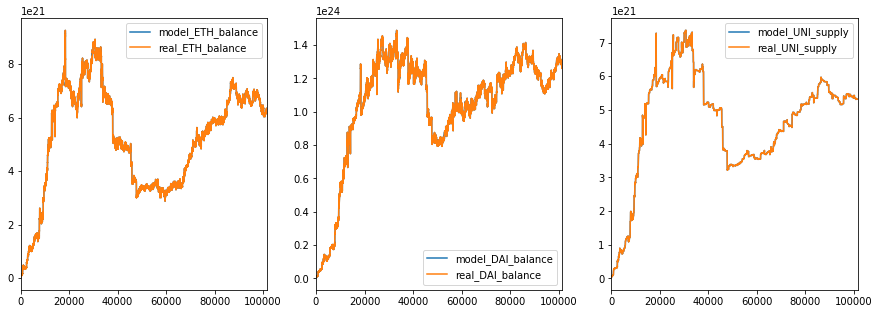

In [215]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
ax = plt.subplot(131)
model_history.astype(float).plot(ax=ax, y=['model_ETH_balance'])
real_history.astype(float).plot(ax=ax, y=['real_ETH_balance'])
ax = plt.subplot(132)
model_history.astype(float).plot(ax=ax, y=['model_DAI_balance'])
real_history.astype(float).plot(ax=ax, y=['real_DAI_balance'])
ax = plt.subplot(133)
model_history.astype(float).plot(ax=ax, y=['model_UNI_supply'])
real_history.astype(float).plot(ax=ax, y=['real_UNI_supply'])

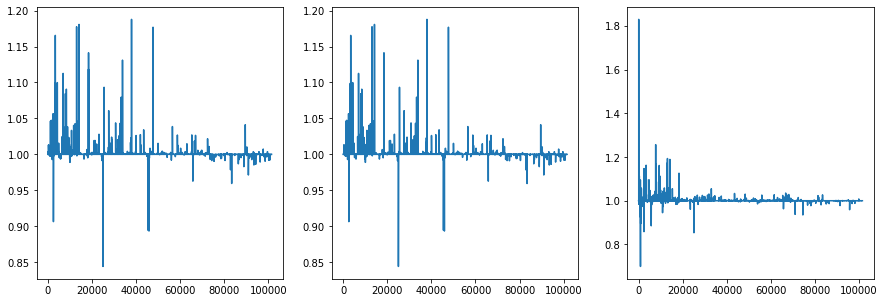

In [216]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
ax = plt.subplot(131)
ax.plot(model_history['model_ETH_balance']/real_history['real_ETH_balance'])
ax = plt.subplot(132)
ax.plot(model_history['model_DAI_balance']/real_history['real_DAI_balance'])
ax = plt.subplot(133)
ax.plot(model_history['model_UNI_supply']/real_history['real_UNI_supply'])

[]

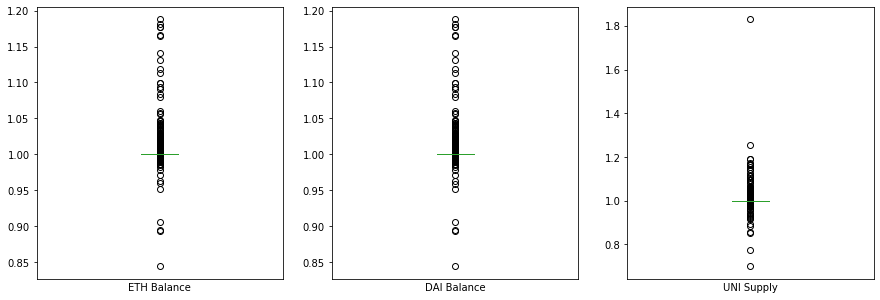

In [217]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
ax = plt.subplot(131)
(model_history['model_ETH_balance']/real_history['real_ETH_balance']).plot.box(ax=ax)
ax.xaxis.set_label_text('ETH Balance')
ax.xaxis.set_ticks([])
ax = plt.subplot(132)
(model_history['model_DAI_balance']/real_history['real_DAI_balance']).plot.box(ax=ax)
ax.xaxis.set_label_text('DAI Balance')
ax.xaxis.set_ticks([])
ax = plt.subplot(133)
(model_history['model_UNI_supply']/real_history['real_UNI_supply']).plot.box(ax=ax)
ax.xaxis.set_label_text('UNI Supply')
ax.xaxis.set_ticks([])

Only if we look much more closely can we see some deviation

In [218]:
model_history.tail(1)

,model_DAI_balance,model_ETH_balance,model_UNI_supply
101484,1268445487370480899199906,6306058808358170889735,5320123300661846672003


In [219]:
real_history.tail(1)

,real_DAI_balance,real_ETH_balance,real_UNI_supply
101484,1268456444556868663822658,6306033015368245238058,5320135262833503868378


In [220]:
model_history.iloc[-1]['model_DAI_balance']/real_history.iloc[-1]['real_DAI_balance']

0.9999913617953263

In [221]:
model_history.iloc[-1]['model_ETH_balance']/real_history.iloc[-1]['real_ETH_balance']

1.0000040902085134

In [222]:
model_history.iloc[-1]['model_UNI_supply']/real_history.iloc[-1]['real_UNI_supply']

0.9999977515286612

_____________

## Model v2
In this version of the model, we modify the policy function in such a way that we don't merely repeat the actions that the traders took in the history of Uniswap. Instead, we assume that traders intend to move the spot price of the Uniswap instance to a specified value - the same value they actually moved the price to in the history of Uniswap.

This is very similar to mimicking the past actions of the traders. Indeed, we should see approximately the same results as the ones we had in the previous simulation. But this model will allow us to build more sophisticated models and simulations in the next step.

In [223]:
def actionDecoder(params, step, history, current_state):

    def getInputFromFinalSpotPrice(spot_price, input_reserve, output_reserve, params):
        a = params['fee_numerator']
        b = params['fee_denominator']
        I = input_reserve
        O = output_reserve
        P = spot_price
        input_amount = - (a*I*P + b*I*P - sqrt(a**2 * I**2 * P**2 - 
                                               2 * a * b * I**2 * P**2 + 
                                               b**2 * I**2 * P**2 +
                                               4 * a * b * O * I * P)) / (2*a*P) 
        return input_amount


    prev_timestep = current_state['timestep']
    if step > 1:
        prev_timestep -= 1
    #skip the first two events, as they are already accounted for in the initial conditions of the system
    data_counter = prev_timestep + 2 
    
    action = {
        'eth_sold': 0,
        'tokens_sold': 0,
        'eth_deposit': 0,
        'UNI_burn': 0,        
    }
    
    event = uniswap_events['event'][data_counter]
    
    action['action_id'] = event
    
    if event == 'TokenPurchase':
        R_i = current_state['ETH_balance']
        R_o = current_state['DAI_balance']
        sp = uniswap_events['token_balance'][data_counter] / uniswap_events['eth_balance'][data_counter]
        action['eth_sold'] = getInputFromFinalSpotPrice(sp, R_i, R_o, params)
    elif event == 'EthPurchase':
        R_i = current_state['DAI_balance']
        R_o = current_state['ETH_balance']
        sp = uniswap_events['eth_balance'][data_counter] / uniswap_events['token_balance'][data_counter]
        action['tokens_sold'] = getInputFromFinalSpotPrice(sp, R_i, R_o, params)
    elif event == 'AddLiquidity':
        action['eth_deposit'] = uniswap_events['eth_delta'][data_counter]
    elif event == 'Transfer':
        UNI_delta = uniswap_events['uni_delta'][data_counter]
        if UNI_delta < 0:
            action['UNI_burn'] = -UNI_delta

    return action

In [224]:
PSUBs = [
    {
        'policies': {
            'user_action': actionDecoder
        },
        'variables': {
            'DAI_balance': mechanismHub_DAI,
            'ETH_balance': mechanismHub_ETH,
            'UNI_supply': mechanismHub_UNI
        }
    }
]

In [225]:
# the number of timesteps in our simulation is the length of the events dataset minus the first two events
# as they are already accounted for in the initial conditions of the system
simulation_parameters = {
    'T': range(len(uniswap_events)-2),
    'N': 1,
    'M': params
}

In [226]:
from cadCAD.configuration import Configuration

config = Configuration(initial_state=state,
                       partial_state_update_blocks=PSUBs, 
                       sim_config=simulation_parameters 
                      )

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.multi_proc)
executor = Executor(exec_context, [config])
raw_result, tensor = executor.execute()[0]

df = pd.DataFrame(raw_result)
prev_dai = pd.Series([np.nan]).append(df['DAI_balance'][:-1]).reset_index(drop=True)
prev_eth = pd.Series([np.nan]).append(df['ETH_balance'][:-1]).reset_index(drop=True)
df['delta_dai'] = df['DAI_balance'] - prev_dai
df['delta_eth'] = df['ETH_balance'] - prev_eth
df['istrade'] = (df['delta_dai'] > 0) != (df['delta_eth'] > 0)
df['volume'] = abs(df[df['istrade']]['delta_dai'])
df = df.drop(columns=['delta_dai','delta_eth','istrade'])


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x12863f5c0>]
Configurations: [<cadCAD.configuration.Configuration object at 0x12863f5c0>]


_____________

## ANALYSIS

In [227]:
model_history = df[['DAI_balance', 'ETH_balance', 'UNI_supply']]
model_history.columns = ['model_DAI_balance', 'model_ETH_balance', 'model_UNI_supply']

In [228]:
real_history = uniswap_events.iloc[1:][['token_balance','eth_balance','UNI_supply']].reset_index(drop=True)
real_history.columns = ['real_DAI_balance', 'real_ETH_balance', 'real_UNI_supply']

Despite the simplifications, the outputs of the model are very similar to the real data

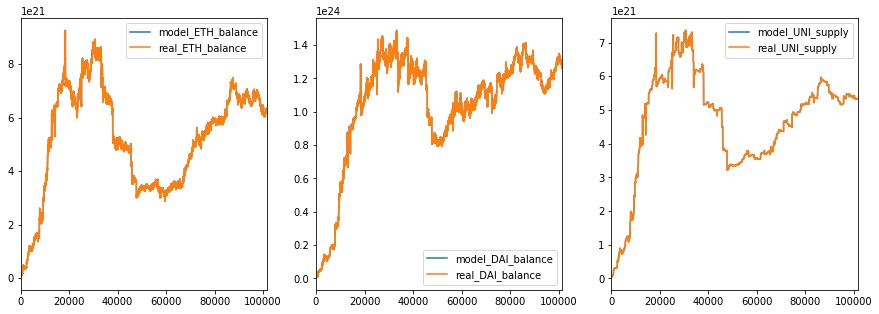

In [229]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
ax = plt.subplot(131)
model_history.astype(float).plot(ax=ax, y=['model_ETH_balance'])
real_history.astype(float).plot(ax=ax, y=['real_ETH_balance'])
ax = plt.subplot(132)
model_history.astype(float).plot(ax=ax, y=['model_DAI_balance'])
real_history.astype(float).plot(ax=ax, y=['real_DAI_balance'])
ax = plt.subplot(133)
model_history.astype(float).plot(ax=ax, y=['model_UNI_supply'])
real_history.astype(float).plot(ax=ax, y=['real_UNI_supply'])

[]

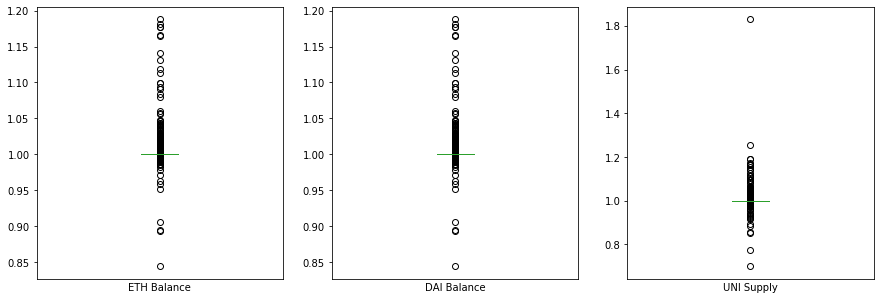

In [230]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
ax = plt.subplot(131)
(model_history['model_ETH_balance']/real_history['real_ETH_balance']).plot.box(ax=ax)
ax.xaxis.set_label_text('ETH Balance')
ax.xaxis.set_ticks([])
ax = plt.subplot(132)
(model_history['model_DAI_balance']/real_history['real_DAI_balance']).plot.box(ax=ax)
ax.xaxis.set_label_text('DAI Balance')
ax.xaxis.set_ticks([])
ax = plt.subplot(133)
(model_history['model_UNI_supply']/real_history['real_UNI_supply']).plot.box(ax=ax)
ax.xaxis.set_label_text('UNI Supply')
ax.xaxis.set_ticks([])

Only if we look much more closely can we see some deviation

In [231]:
model_history.tail(1)

,model_DAI_balance,model_ETH_balance,model_UNI_supply
101484,1268456528584669092156778,6306033433105949044024,5320135546652624442495


In [232]:
real_history.tail(1)

,real_DAI_balance,real_ETH_balance,real_UNI_supply
101484,1268456444556868663822658,6306033015368245238058,5320135262833503868378


In [233]:
model_history.iloc[-1]['model_DAI_balance']/real_history.iloc[-1]['real_DAI_balance']

1.0000000662441353

In [234]:
model_history.iloc[-1]['model_ETH_balance']/real_history.iloc[-1]['real_ETH_balance']

1.0000000662441353

In [235]:
model_history.iloc[-1]['model_UNI_supply']/real_history.iloc[-1]['real_UNI_supply']

1.0000000533481024

_____________

## Model v3
Now we start doing some user segmentation. We will classify the traders under two categories with different state-dependent behavioral models. **Keep in mind these are extremely naïve models, for illustration purposes only:**
1. Arbitrageurs: actors that seek to make a profit from buying tokens in the Uniswap exchange and selling them at a higher price at another exchange. These actors are not very sensitive to trading fees: higher fees reduce their margins, but we assume a small fixed cost of executing the trade (see configuration parameters), so any profit above that threshold will cause them to execute the trade.
1. Swapper: people who use Uniswap's web UI to swap tokens - buy or sell a specific amount. They are sensitive to trading fees, and are looking for an effective trading price that is not too far from the current spot price. If the effective price is above their threshold, they take their business elsewhere.

We will classify each one of the trades in the historical dataset as having been performed by either an _Arbitrageur_ or a _Swapper_ according to a simple, naïve heuristic: trades that resulted in a _"round"_ amount of tokens being sold or bought are classified as having been performed by swappers. All other trades are classified as coming from arbitrageurs. Our definition of _"round"_ is to the third decimal place. Examples:
* Buy 0.001 ether for 0.245892 DAI => Swapper
* Sell 245.92348923 ether for 1.001 DAI => Swapper
* Buy 0.0011 ether for 0.2345 DAI => Arbitrageur

In [185]:
def getInputFromFinalSpotPrice(spot_price, input_reserve, output_reserve, params):
    a = params['fee_numerator']
    b = params['fee_denominator']
    I = input_reserve
    O = output_reserve
    P = spot_price
    input_amount = - (a*I*P + b*I*P - sqrt(a**2 * I**2 * P**2 - 
                                           2 * a * b * I**2 * P**2 + 
                                           b**2 * I**2 * P**2 +
                                           4 * a * b * O * I * P)) / (2*a*P) 
    return input_amount

def actionDecoder(params, step, history, current_state):

    def getInputFromFinalSpotPrice(spot_price, input_reserve, output_reserve, params):
        a = params['fee_numerator']
        b = params['fee_denominator']
        I = input_reserve
        O = output_reserve
        P = spot_price
        input_amount = - (a*I*P + b*I*P - sqrt(a**2 * I**2 * P**2 - 
                                               2 * a * b * I**2 * P**2 + 
                                               b**2 * I**2 * P**2 +
                                               4 * a * b * O * I * P)) / (2*a*P) 
        return input_amount
    


    prev_timestep = current_state['timestep']
    if step > 1:
        prev_timestep -= 1
    #skip the first two events, as they are already accounted for in the initial conditions of the system
    data_counter = prev_timestep + 2 
    
    action = {
        'eth_sold': 0,
        'tokens_sold': 0,
        'eth_deposit': 0,
        'UNI_burn': 0,        
    }
    
    event = uniswap_events['event'][data_counter]
    
    isArbitrageur = ( (uniswap_events['eth_delta'][data_counter] % int(1E15) != 0) & 
                      (uniswap_events['token_delta'][data_counter] % int(1E15) != 0) )
    
    
    if (event == 'TokenPurchase') or (event == 'EthPurchase'):
        market_price = uniswap_events['token_balance'][data_counter] / uniswap_events['eth_balance'][data_counter]
        pool_price = current_state['DAI_balance'] / current_state['ETH_balance']
        if market_price > pool_price:
            event = 'TokenPurchase'
        else:
            event = 'EthPurchase'
    
    action['action_id'] = event
    if event == 'TokenPurchase':
        R_i = current_state['ETH_balance']
        R_o = current_state['DAI_balance']
        sp = uniswap_events['token_balance'][data_counter] / uniswap_events['eth_balance'][data_counter]
        if (isArbitrageur):
            would_sell = getInputFromFinalSpotPrice(sp, R_i, R_o, params)
            if (would_sell<0):
                action['eth_sold'] = 0
            else:
                would_buy = getInputPrice(would_sell, R_i, R_o, params)
                would_profit = would_buy / sp - would_sell
                if would_profit > params['arbitrageur_fixed_cost_ETH']:
                    action['eth_sold'] = would_sell
                else:
                    action['eth_sold'] = 0
        else:
            sold = uniswap_events['eth_delta'][data_counter]
            got = -uniswap_events['token_delta'][data_counter]
            effective_price = got/sold
            slippage = effective_price/sp

            wants_to_sell = sold
            would_get = getInputPrice(wants_to_sell, R_i, R_o, params)
            would_effective_price = would_get/wants_to_sell
            would_slippage = would_effective_price/sp
            
            if abs(slippage/would_slippage-1) <= params['additional_slippage_tolerance']:
                action['eth_sold'] = wants_to_sell
            else:
                action['eth_sold'] = 0            
    elif event == 'EthPurchase':
        R_i = current_state['DAI_balance']
        R_o = current_state['ETH_balance']
        sp = uniswap_events['eth_balance'][data_counter] / uniswap_events['token_balance'][data_counter]
        if (isArbitrageur):
            would_sell = getInputFromFinalSpotPrice(sp, R_i, R_o, params)
            if (would_sell<0):
                action['tokens_sold'] = 0
            else:
                would_buy = getInputPrice(would_sell, R_i, R_o, params)
                would_profit = would_buy - would_sell / sp
                if would_profit > params['arbitrageur_fixed_cost_ETH']:
                    action['tokens_sold'] = would_sell
                else:
                    action['tokens_sold'] = 0
        else:
            sold = uniswap_events['token_delta'][data_counter]
            got = -uniswap_events['eth_delta'][data_counter]
            effective_price = got/sold
            slippage = effective_price/sp

            wants_to_sell = sold
            would_get = getInputPrice(wants_to_sell, R_i, R_o, params)
            would_effective_price = would_get/wants_to_sell
            would_slippage = would_effective_price/sp
            
            if abs(slippage/would_slippage-1) <= params['additional_slippage_tolerance']:
                action['tokens_sold'] = wants_to_sell
            else:
                action['tokens_sold'] = 0            
#     elif event == 'AddLiquidity':
#         action['eth_deposit'] = uniswap_events['eth_delta'][data_counter]
#     elif event == 'Transfer':
#         UNI_delta = uniswap_events['uni_delta'][data_counter]
#         if UNI_delta < 0:
#             burn = - UNI_delta
#             perc_burn = burn/(uniswap_events['UNI_supply'][data_counter] + burn)
#             action['UNI_burn'] = int(perc_burn * current_state['UNI_supply'])
    return action

In [236]:
PSUBs = [
    {
        'policies': {
            'user_action': actionDecoder
        },
        'variables': {
            'DAI_balance': mechanismHub_DAI,
            'ETH_balance': mechanismHub_ETH,
            'UNI_supply': mechanismHub_UNI        }
    }
]

In [237]:
params = {
    'fee_numerator': [997, 990, 970],
    'fee_denominator': [1000],
    'additional_slippage_tolerance': [0.03, 0.01],
    'arbitrageur_fixed_cost_ETH': [0.0001]
}
params

{'fee_numerator': [997, 990, 970],
 'fee_denominator': [1000],
 'additional_slippage_tolerance': [0.03, 0.01],
 'arbitrageur_fixed_cost_ETH': [0.0001]}

In [238]:
def concat(d1, d2, key):
    res = []
    if len(d1) > 0:
        for d in d1:
            tmp = d.copy()
            for j in d2:
                tmp[key] = j
                res.append(tmp.copy())
    else:
        tmp = {}
        for j in d2:
            tmp[key] = j
            res.append(tmp.copy())
    return res

p = []
for k in params.keys():
    p = concat(p, params[k], k)
# p    
params_labels = [f"{i['fee_numerator']};{i['additional_slippage_tolerance']};{i['arbitrageur_fixed_cost_ETH']}" for i in p]
params_labels

['997;0.03;0.0001',
 '997;0.01;0.0001',
 '990;0.03;0.0001',
 '990;0.01;0.0001',
 '970;0.03;0.0001',
 '970;0.01;0.0001']

In [239]:
simulation_parameters = [{'T': range(len(uniswap_events)-2),
                          'N': 1,
                          'M': param} for param in p]

In [240]:
from cadCAD.configuration import Configuration

config = []
for s in simulation_parameters:
    config.append(Configuration(initial_state=state,
                                partial_state_update_blocks=PSUBs, 
                                sim_config=s))

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.multi_proc)
executor = Executor(exec_context, config)

d = pd.DataFrame()
for i, t in enumerate(executor.execute()):
    r = t[0]
    df = pd.DataFrame(r)
    prev_dai = pd.Series([np.nan]).append(df['DAI_balance'][:-1]).reset_index(drop=True)
    prev_eth = pd.Series([np.nan]).append(df['ETH_balance'][:-1]).reset_index(drop=True)
    df['delta_dai'] = df['DAI_balance'] - prev_dai
    df['delta_eth'] = df['ETH_balance'] - prev_eth
    df['istrade'] = (df['delta_dai'] > 0) != (df['delta_eth'] > 0)
    df['volume'] = abs(df[df['istrade']]['delta_dai'])
    df['volume'] = df['volume'].fillna(0)
    df = df.drop(columns=['delta_dai','delta_eth','istrade'])
    df = df.set_index(pd.MultiIndex.from_arrays([[i]*len(df),list(df.index)]))
    d = d.append(df)

df = d
df


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x19be23c88>, <cadCAD.configuration.Configuration object at 0x19be23d30>, <cadCAD.configuration.Configuration object at 0x19be23d68>, <cadCAD.configuration.Configuration object at 0x19be23da0>, <cadCAD.configuration.Configuration object at 0x19be23dd8>, <cadCAD.configuration.Configuration object at 0x19be23e10>]
Configurations: [<cadCAD.configuration.Configuration object at 0x19be23c88>, <cadCAD.configuration.Configuration object at 0x19be23d30>, <cadCAD.configuration.Configuration object at 0x19be23d68>, <cadCAD.configuration.Configuration object at 0x19be23da0>, <cadCAD.configuration.Configuration object at 0x19be23dd8>, <cadCAD.configuration.Con

DAI_balance              ETH_balance  \
0 0           5900000000000000000000     30000000000000000000   
  1           5905000000000000066560     29974673940746673872   
  2           5907000000000000183040     29964555511671267270   
  3           5905035238623641703247     29974555511671267882   
  4           5903071785798411115538     29984555511671269900   
...                              ...                      ...   
5 101480  15545546022016410319444419  77185977099553704772272   
  101481  15545856412622732098918851  77184482226484795378460   
  101482  15536736890618695803673162  77231187995294648896284   
  101483  15536682291665283862412407  77231467794846175982780   
  101484  15535895329565092886560421  77235500905013956388540   

                        UNI_supply  run  substep  timestep  \
0 0           30000000000000000000    1        0         0   
  1           30000000000000000000    1        1         1   
  2           30000000000000000000    1        1         2   
  3           30000000000000000000    1        1         3   
  4           30000000000000000000    1        1         4   
...                            ...  ...      ...       ...   
5 101480  -12061886437396886196597    1        1    101480   
  101481  -12061886437396886196597    1        1    101481   
  101482  -12061886437396886196597    1        1    101482   
  101483  -12061886437396886196597    1        1    101483   
  101484  -12061886437396886196597    1        1    101484   

                          volume  
0 0                            0  
  1          5000000000000066560  
  2          2000000000000116480  
  3          1964761376358479793  
  4          1963452825230587709  
...                          ...  
5 101480   496624756282840776704  
  101481   310390606321779474432  
  101482  9119522004036295245689  
  101483    54598953411941260755  
  101484   786962100190975851986  

[608910 rows x 7 columns]

_____________

## ANALYSIS

In [241]:
plot_data = df.copy()
plot_data[['DAI_balance',
           'ETH_balance',
           'UNI_supply',
           'volume']] = plot_data[['DAI_balance',
                                   'ETH_balance',
                                   'UNI_supply',
                                   'volume']]*1E-18
plot_data['ETH_price_DAI'] = plot_data['DAI_balance'] / plot_data['ETH_balance']
plot_data['UNI_price_DAI'] = 2 * plot_data['DAI_balance'] / plot_data['UNI_supply']
for i in plot_data.index.levels[0]:
    a = 0.5 * plot_data.loc[i]['ETH_price_DAI'][0] + 0.5 * plot_data.loc[i]['ETH_price_DAI']
    plot_data.loc[i,'50_50_hodler_value'] = a.values

    a = plot_data.loc[i]['50_50_hodler_value']/plot_data.loc[i]['50_50_hodler_value'][0] - 1
    plot_data.loc[i,'50_50_hodler_return'] = a.values
    
    a = plot_data.loc[i]['UNI_price_DAI']/plot_data.loc[i]['UNI_price_DAI'][0] - 1
    plot_data.loc[i,'UNI_hodler_return'] = a.values
    
    a = plot_data.loc[i]['ETH_price_DAI']/plot_data.loc[i]['ETH_price_DAI'][0] - 1
    plot_data.loc[i,'ETH_hodler_return'] = a.values

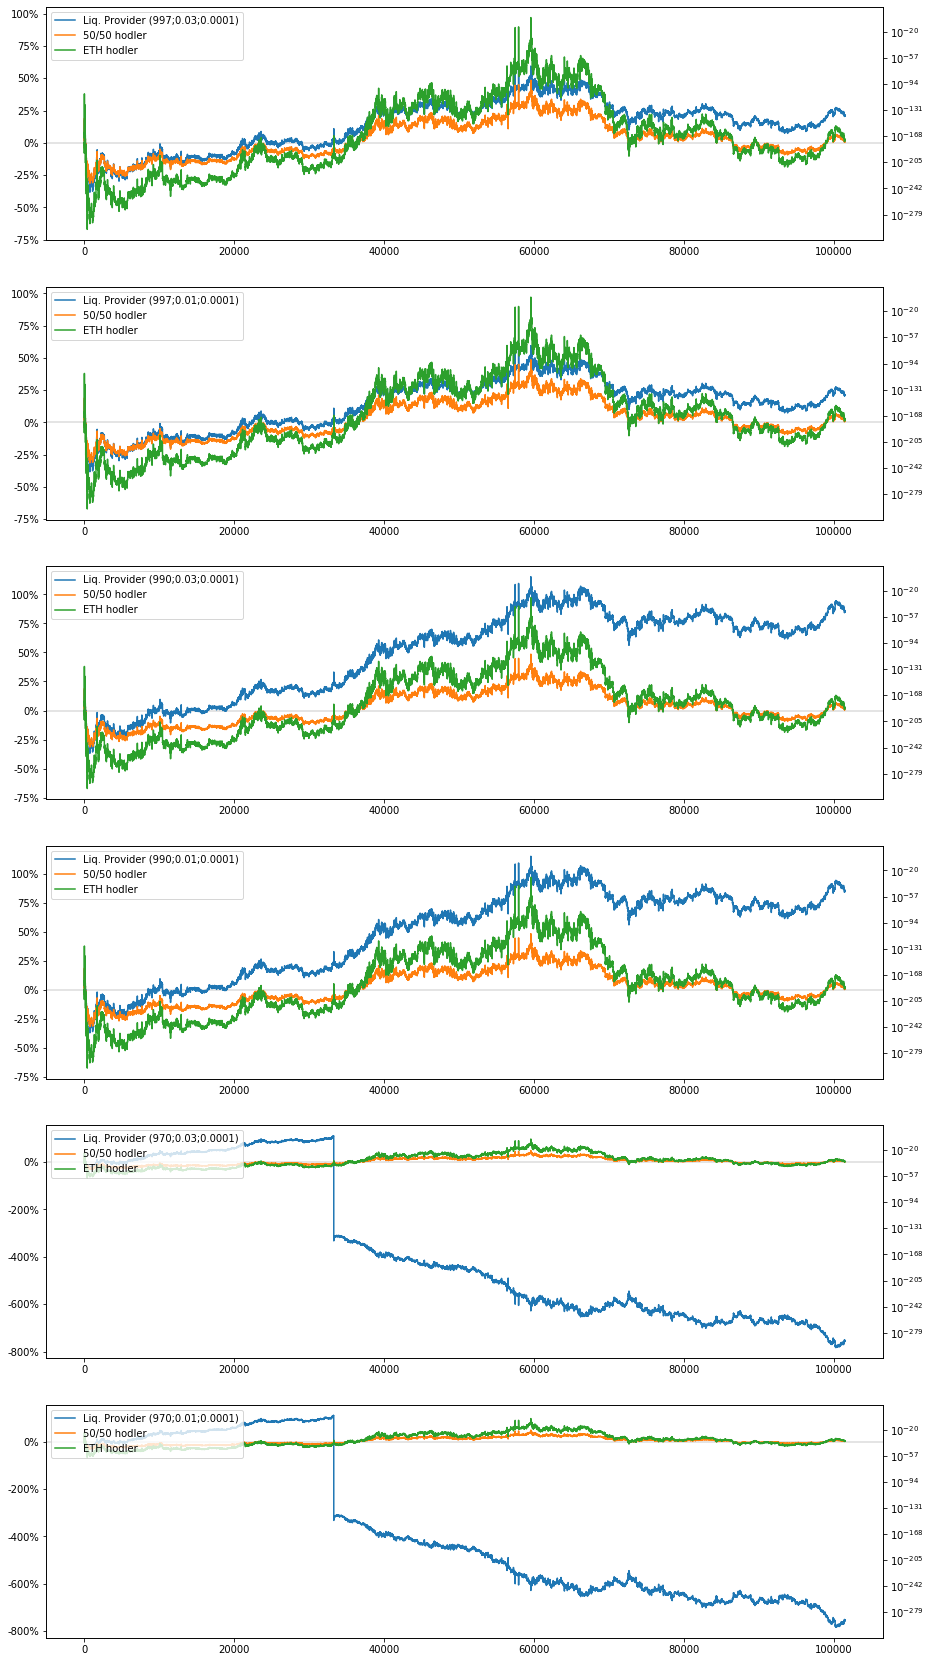

In [242]:
# %%capture --no-display cell_capture
#avoid warnings in cell output

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib import animation, rc
rc('animation', html='jshtml', embed_limit=50)
from matplotlib import cm
import matplotlib.ticker as ticker


nplots = len(plot_data.index.levels[0])
fig, axs = plt.subplots(ncols=1, nrows=nplots,
                        figsize=(15,5*nplots))


plt.close()


for i in range(nplots):
    axs[i].axhline(0, color='gainsboro')
    ema = ExpMovingAverage(plot_data.loc[i].UNI_hodler_return, 1)
    axs[i].plot(ema, label=f'Liq. Provider ({params_labels[i]})')
    axs[i].plot(plot_data.loc[i]['50_50_hodler_return'], label=f'50/50 hodler')
    axs[i].plot(plot_data.loc[i].ETH_hodler_return, label=f'ETH hodler')
    axs[i].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    axs[i].yaxis.tick_right()
    axs[i].legend(loc='upper left')
    sec_ax = axs[i].twinx()
#     sec_ax.plot(plot_data.loc[i]['volume'], label='Volume')
    sec_ax.set_yscale('log')
fig

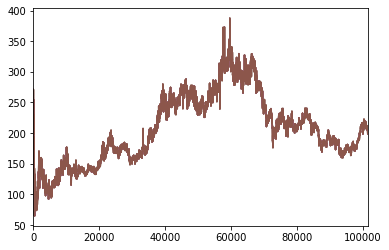

In [243]:
ax = None
for i in plot_data.index.levels[0]:
    ax = plot_data.loc[i].ETH_price_DAI.plot(ax=None)

In [244]:
plot_data.loc[5]

,DAI_balance,ETH_balance,UNI_supply,run,substep,timestep,volume,ETH_price_DAI,UNI_price_DAI,50_50_hodler_value,50_50_hodler_return,UNI_hodler_return,ETH_hodler_return
0,5900,30,30,1,0,0,0,196.667,393.333,196.667,0,0,0
1,5905.07,29.975,30,1,1,1,5.06853,197,393.671,196.833,0.000846544,0.000859073,0.00169309
2,5907.1,29.965,30,1,1,2,2.02743,197.133,393.806,196.9,0.00118536,0.00120271,0.00237072
3,5905.16,29.9752,30,1,1,3,1.93779,197.002,393.677,196.834,0.000851512,0.000874266,0.00170302
4,5903.22,29.9853,30,1,1,4,1.93651,196.87,393.548,196.769,0.000517996,0.000546044,0.00103599
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101480,1.55455e+07,77186,-12061.9,1,1,101480,496.625,201.404,-2577.63,199.035,0.0120435,-7.5533,0.0240869
101481,1.55459e+07,77184.5,-12061.9,1,1,101481,310.391,201.412,-2577.68,199.039,0.0120636,-7.55343,0.0241272
101482,1.55367e+07,77231.2,-12061.9,1,1,101482,9119.52,201.172,-2576.17,198.919,0.0114537,-7.54959,0.0229074
101483,1.55367e+07,77231.5,-12061.9,1,1,101483,54.599,201.17,-2576.16,198.919,0.0114501,-7.54956,0.0229001


In [245]:
buggy = plot_data.loc[5]
buggy[abs(buggy['50_50_hodler_return'])<0.0001]
k = buggy['DAI_balance']*buggy['ETH_balance']
buggy[(k - pd.Series([0]).append(k[:-1]).reset_index(drop=True))<0]

,DAI_balance,ETH_balance,UNI_supply,run,substep,timestep,volume,ETH_price_DAI,UNI_price_DAI,50_50_hodler_value,50_50_hodler_return,UNI_hodler_return,ETH_hodler_return
102,12836.3,59.9454,61.9576,1,1,102,0,214.133,414.357,205.4,0.0444052,0.0534507,0.0888105
252,13379.5,77.04,70.1814,1,1,252,0,173.669,381.282,185.168,-0.058469,-0.0306385,-0.116938
347,13289.9,100.003,78.5668,1,1,347,0,132.895,338.308,164.781,-0.162132,-0.139894,-0.324263
415,11799.8,112.525,77.5668,1,1,415,0,104.864,304.249,150.765,-0.233396,-0.226486,-0.466792
418,11832.6,111.652,77.3668,1,1,418,0,105.978,305.884,151.322,-0.230566,-0.222329,-0.461131
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52820,4.69732e+06,18876.6,-6566.25,1,1,52820,6.59707e-09,248.844,-1430.75,222.755,0.132654,-4.63749,0.265307
69080,8.74614e+06,31727.8,-8473.12,1,1,69080,1.09951e-09,275.661,-2064.44,236.164,0.200834,-6.24859,0.401669
78409,1.02661e+07,46870.6,-9503.33,1,1,78409,2.19902e-09,219.032,-2160.54,207.849,0.0568602,-6.49289,0.11372
85513,1.18462e+07,54936.8,-10302,1,1,85513,2.10051e-08,215.633,-2299.78,206.15,0.0482191,-6.84691,0.0964383


In [246]:
buggy.head(20)

,DAI_balance,ETH_balance,UNI_supply,run,substep,timestep,volume,ETH_price_DAI,UNI_price_DAI,50_50_hodler_value,50_50_hodler_return,UNI_hodler_return,ETH_hodler_return
0,5900,30,30,1,0,0,0,196.667,393.333,196.667,0,0,0
1,5905.07,29.975,30,1,1,1,5.06853,197,393.671,196.833,0.000846544,0.000859073,0.00169309
2,5907.1,29.965,30,1,1,2,2.02743,197.133,393.806,196.9,0.00118536,0.00120271,0.00237072
3,5905.16,29.9752,30,1,1,3,1.93779,197.002,393.677,196.834,0.000851512,0.000874266,0.00170302
4,5903.22,29.9853,30,1,1,4,1.93651,196.87,393.548,196.769,0.000517996,0.000546044,0.00103599
5,5901.29,29.9955,30,1,1,5,1.93523,196.739,393.419,196.703,0.000184812,0.000218039,0.000369625
6,5903.19,30.0051,30.0097,1,1,6,0,196.739,393.419,196.703,0.000184812,0.000218039,0.000369625
7,5903.19,30.0051,30.0097,1,1,7,0,196.739,393.419,196.703,0.000184812,0.000218039,0.000369625
8,5896.94,30.0379,30.0097,1,1,8,6.24831,196.317,393.003,196.492,-0.000889821,-0.000840655,-0.00177964
9,5890.72,30.0706,30.0097,1,1,9,6.22169,195.896,392.588,196.281,-0.00195871,-0.00189484,-0.00391742


In [247]:
uniswap_events.head(20)[['event','eth_balance','token_balance']]

,event,eth_balance,token_balance
0,AddLiquidity,30000000000000000000,5900000000000000000000
1,Transfer,30000000000000000000,5900000000000000000000
2,EthPurchase,29974673940746674209,5905000000000000000000
3,EthPurchase,29964555511671268196,5907000000000000000000
4,TokenPurchase,29974555511671268196,5905035238623641640532
5,TokenPurchase,29984555511671268196,5903071785798411448958
6,TokenPurchase,29994555511671268196,5901109640216828255225
7,AddLiquidity,30004212911671268196,5903009630907380568837
8,Transfer,30004212911671268196,5903009630907380568837
9,TokenPurchase,30036545047335992753,5896674516410174307748
